In [1]:
# standard python tools
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from skimage.io import imread
import SimpleITK as sitk

In [2]:
# make sure pyqae is available
import pyqae as pq
import pyspark

from pyqae.images import viz
from pyqae.sitk import read_to_dataframe, ITKImage, apply_filter, show_first_image, save_itk_local, fix_df_col_names

# DataFrame Representation
The dataframe representation of the files is shown below. The columns are listed in the subsequent fields. The ```itk_```, ```array``` and ```array_dtype``` are necessary for recreating the ITK image and should not be modified

In [3]:
base_path = "/Users/mader/Dropbox/4Quant/Projects/TumorSegmentation/10092825/"
mri_df = read_to_dataframe(glob(os.path.join(base_path,"0004_t1_tse_sag_384/*.tif")), context = sc)

In [4]:
", ".join(mri_df.columns)

'ImageDescription, Tag 50838, Tag 50839, array, array_dtype, filename, itk_Depth, itk_Dimension, itk_Direction, itk_Height, itk_NumberOfComponentsPerPixel, itk_Origin, itk_PixelID, itk_PixelIDTypeAsString, itk_PixelIDValue, itk_Size, itk_Spacing, itk_Width'

# Running SQL Commands
The ```DataFrame``` can be registered as a table which allows for further processing to be done using SQL and the DataFrame interface

In [5]:
mri_df.registerTempTable("TestTable")

In [6]:
sqlContext.sql("""SELECT filename, itk_Size, itk_Spacing, ImageDescription FROM TESTTable ORDER BY itk_Size._1 LIMIT 2""").toPandas()

,filename,itk_Size,itk_Spacing,ImageDescription
0,/Users/mader/Dropbox/4Quant/Projects/TumorSegm...,"(384, 384)","(1.0, 1.0)",ImageJ=1.49v\nunit=mm\nmin=0.0\nmax=1128.0\n
1,/Users/mader/Dropbox/4Quant/Projects/TumorSegm...,"(384, 384)","(1.0, 1.0)",ImageJ=1.49v\nunit=mm\nmin=0.0\nmax=1128.0\n


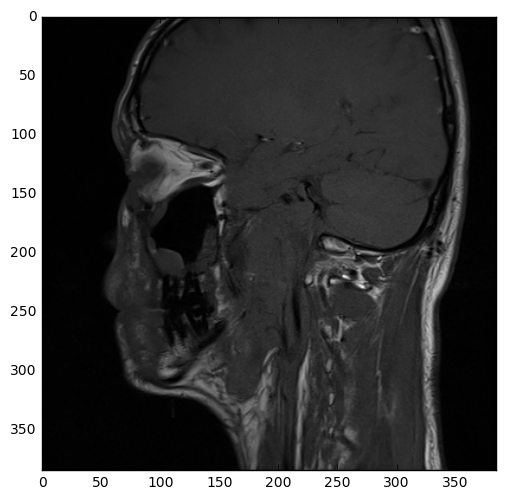

In [7]:
show_first_image(sqlContext.sql("""SELECT * FROM TESTTable LIMIT 2"""))

# 3D Volumes
The tools can also be applied for looking at 3D volumes by taking stacks of slices together.

In [8]:
fold_name = lambda x: os.path.split(os.path.split(x)[0])[1]
base_path = "/Users/mader/Dropbox/4Quant/Projects/TumorSegmentation/10092825/"
# now group the files by folder before loading them (each is turned into a list of filenames)
grp_paths = sc.parallelize(glob(os.path.join(base_path,"*/*.dcm"))).groupBy(fold_name).map(lambda x: list(x[1]))
mri_3d_df = read_to_dataframe(grp_paths)
mri_3d_df.registerTempTable("TdTable")

In [9]:
sqlContext.sql("""
SELECT  
itk_Size as ImageDimensions, 
itk_Size._1*itk_Size._2*itk_Size._3 as VoxelCount,
itk_Spacing as ImageResolution 
FROM TdTable ORDER BY VoxelCount DESC LIMIT 2""").toPandas()

,ImageDimensions,VoxelCount,ImageResolution
0,"(130, 130, 240)",4056000,"(2.0, 2.0, 4.999996185302734)"
1,"(384, 384, 16)",2359296,"(0.57291668653488, 0.57291668653488, 6.0)"


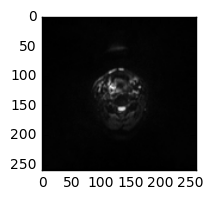

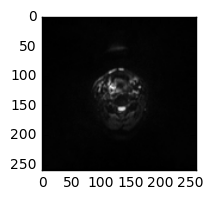

In [10]:
show_first_image(sqlContext.sql("""SELECT * FROM TdTable
ORDER BY itk_Size._1*itk_Size._2*itk_Size._3 DESC LIMIT 1"""))

# Applying Filters
Filters can be appled to these dataframes where each image has the same filter

In [11]:
post_filt_df = apply_filter(mri_3d_df, sitk.GradientMagnitude)

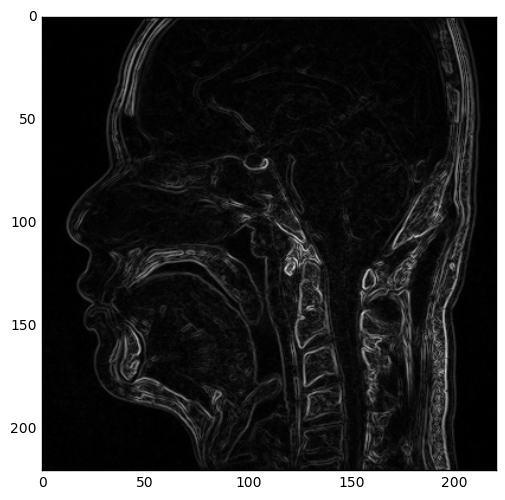

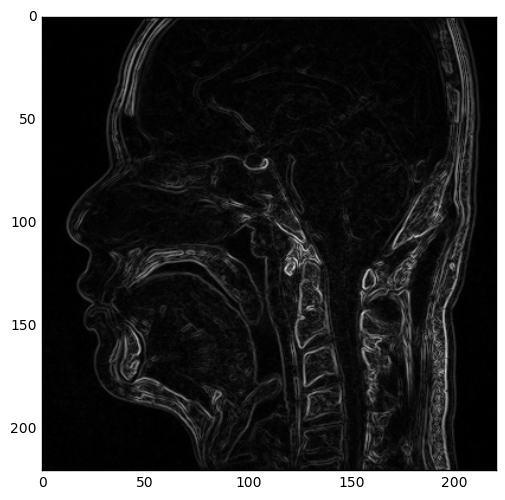

In [12]:
_ = show_first_image(post_filt_df)

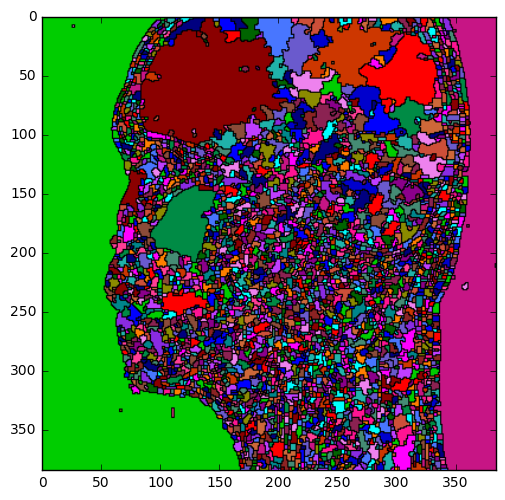

In [13]:
def fancy_segment_pipeline(in_img):
    feat_img = sitk.GradientMagnitude(in_img)
    ws_img = sitk.MorphologicalWatershed(feat_img, level=8, 
                                         markWatershedLine=True, 
                                         fullyConnected=True)
    return sitk.LabelToRGB(ws_img)
mri_label_df = apply_filter(mri_df, fancy_segment_pipeline).cache()
show_first_image(mri_label_df)

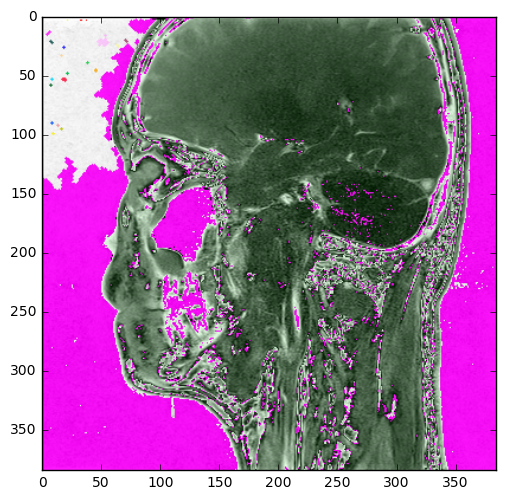

In [14]:
def fancy_segment_pipeline_layout(in_img):
    feat_img = sitk.GradientMagnitude(in_img)
    ws_img = sitk.MorphologicalWatershed(feat_img, level = 4, 
                                         markWatershedLine = True, 
                                         fullyConnected = False)
    seg = sitk.ConnectedComponent(ws_img!=ws_img[0,0]) # for 2d images
    return sitk.LabelOverlay(in_img, seg)
mri_label_df = apply_filter(mri_df, fancy_segment_pipeline_layout).cache()
show_first_image(mri_label_df)

# Saving and Exporting
The DataFrames can be exported in Spark native formats like parquet or using ITK based file formats where each object is saved individually

In [15]:
fix_df_col_names(mri_df).write.parquet("big_filt_volume_pqt")

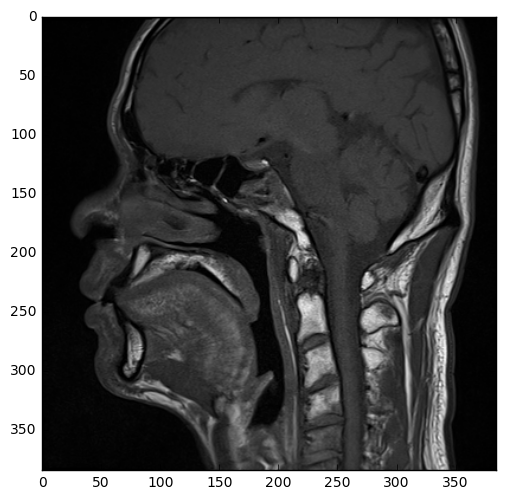

In [16]:
show_first_image(sqlContext.read.parquet("big_filt_volume_pqt"))

In [17]:
save_itk_local(mri_label_df,"nice_label_data", True)

('nice_label_data',
 ['nice_label_data/0.tif',
  'nice_label_data/4.tif',
  'nice_label_data/8.tif',
  'nice_label_data/1.tif',
  'nice_label_data/5.tif',
  'nice_label_data/9.tif',
  'nice_label_data/2.tif',
  'nice_label_data/6.tif',
  'nice_label_data/10.tif',
  'nice_label_data/3.tif',
  'nice_label_data/7.tif',
  'nice_label_data/11.tif',
  'nice_label_data/15.tif',
  'nice_label_data/19.tif',
  'nice_label_data/23.tif'])

In [18]:
save_itk_local(post_filt_df,"post_filt_data", True)

('post_filt_data',
 ['post_filt_data/0.tif',
  'post_filt_data/1.tif',
  'post_filt_data/2.tif',
  'post_filt_data/6.tif',
  'post_filt_data/10.tif',
  'post_filt_data/14.tif',
  'post_filt_data/18.tif',
  'post_filt_data/3.tif',
  'post_filt_data/7.tif'])

In [23]:
# can also save in json format (very large)
fix_df_col_names(mri_df).write.json("big_json_vol_json")